In [32]:
# Import Numpy & PyTorch
import numpy as np
import torch

A tensor is a number, vector, matrix or any n-dimensional array.

## Problem Statement

We'll create a model that predicts crop yeilds for apples (*target variable*) by looking at the average temperature, rainfall and humidity (*input variables or features*) in different regions. 

Here's the training data:

>Temp | Rain | Humidity | Prediction
>--- | --- | --- | ---
> 73 | 67 | 43 | 56
> 91 | 88 | 64 | 81
> 87 | 134 | 58 | 119
> 102 | 43 | 37 | 22
> 69 | 96 | 70 | 103

In a **linear regression** model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

```
yeild_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
```

It means that the yield of apples is a linear or planar function of the temperature, rainfall & humidity.



**Our objective**: Find a suitable set of *weights* and *biases* using the training data, to make accurate predictions.

## Training Data
The training data can be represented using 2 matrices (inputs and targets), each with one row per observation and one column for variable.

In [33]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [34]:
# Target (apples)
targets = np.array([[56], 
                    [81], 
                    [119], 
                    [22], 
                    [103]], dtype='float32')
targets

array([[ 56.],
       [ 81.],
       [119.],
       [ 22.],
       [103.]], dtype=float32)

Before we build a model, we need to convert inputs and targets to PyTorch tensors.

In [35]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

targets


tensor([[ 56.],
        [ 81.],
        [119.],
        [ 22.],
        [103.]])

## Linear Regression Model (from scratch)

The *weights* and *biases* can also be represented as matrices, initialized with random values. The first row of `w` and the first element of `b` are use to predict the first target variable i.e. yield for apples, and similarly the second for oranges.

In [36]:
# Weights and biases
W = torch.rand((1,inputs.shape[1]),requires_grad=True)
print(W)

b = torch.zeros(size=(inputs.shape[0],1),requires_grad=True)
print(b)


tensor([[0.1144, 0.0744, 0.3933]], requires_grad=True)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)


The *model* is simply a function that performs a matrix multiplication of the input `x` and the weights `w` (transposed) and adds the bias `b` (replicated for each observation).

$$
\hspace{2.5cm} X \hspace{1.1cm} \times \hspace{1.2cm} W^T \hspace{1.2cm}  + \hspace{1cm} b \hspace{2cm}
$$

$$
\left[ \begin{array}{cc}
73 & 67 & 43 \\
91 & 88 & 64 \\
\vdots & \vdots & \vdots \\
69 & 96 & 70
\end{array} \right]
%
\times
%
\left[ \begin{array}{cc}
w_{11} & w_{21} \\
w_{12} & w_{22} \\
w_{13} & w_{23}
\end{array} \right]
%
+
%
\left[ \begin{array}{cc}
b_{1} & b_{2} \\
b_{1} & b_{2} \\
\vdots & \vdots \\
b_{1} & b_{2} \\
\end{array} \right]
$$

In [37]:
# Define the model
predict = lambda X,W,b: X@W.T+b

The matrix obtained by passing the input data to the model is a set of predictions for the target variables.

In [38]:
# Generate predictions
y_h = predict(inputs,W,b)
print(y_h)

tensor([[30.2470],
        [42.1273],
        [42.7301],
        [29.4215],
        [42.5643]], grad_fn=<AddBackward0>)


In [39]:
# Compare with targets
targets

tensor([[ 56.],
        [ 81.],
        [119.],
        [ 22.],
        [103.]])

Because we've started with random weights and biases, the model does not perform a good job of predicting the target varaibles.

## Loss Function

We can compare the predictions with the actual targets, using the following method: 
* Calculate the difference between the two matrices (`preds` and `targets`).
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the **mean squared error** (MSE).

In [40]:
# MSE loss
loss_fn = torch.nn.MSELoss()
my_loss = lambda Y,Yhat : ((Y-Yhat)**2).mean()

In [41]:
# Compute loss
loss = loss_fn(targets,y_h)

The resulting number is called the **loss**, because it indicates how bad the model is at predicting the target variables. Lower the loss, better the model. 

## Compute Gradients

With PyTorch, we can automatically compute the gradient or derivative of the `loss` w.r.t. to the weights and biases, because they have `requires_grad` set to `True`.

More on autograd:  https://pytorch.org/docs/stable/autograd.html#module-torch.autograd

In [42]:
# Compute gradients
loss.backward()

The gradients are stored in the `.grad` property of the respective tensors.

In [43]:
# Gradients for weights
W.grad

tensor([[-6186.3740, -8339.6465, -4789.9155]])

In [44]:
# Gradients for bias
b.grad

tensor([[-10.3012],
        [-15.5491],
        [-30.5080],
        [  2.9686],
        [-24.1743]])

A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases. 

* If a gradient element is **postive**, 
    * **increasing** the element's value slightly will **increase** the loss.
    * **decreasing** the element's value slightly will **decrease** the loss.




* If a gradient element is **negative**,
    * **increasing** the element's value slightly will **decrease** the loss.
    * **decreasing** the element's value slightly will **increase** the loss.
    


The increase or decrease is proportional to the value of the gradient.

Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.

In [45]:
W.grad.zero_(),b.grad.zero_()

(tensor([[0., 0., 0.]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

## Adjust weights and biases using gradient descent

We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

1. Generate predictions
2. Calculate the loss
3. Compute gradients w.r.t the weights and biases
4. Adjust the weights by subtracting a small quantity proportional to the gradient
5. Reset the gradients to zero

In [74]:
# Generate predictions
X = torch.from_numpy( np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32'))
Y = torch.from_numpy( np.array([[56], 
                    [81], 
                    [119], 
                    [22], 
                    [103]], dtype='float32'))

W = torch.rand((1,X.shape[1]),requires_grad=True)
b = torch.tensor([[0.0]],requires_grad=True)

predict = lambda X,W,b : X@W.T + b

W,b,W.grad,b.grad

(tensor([[0.3575, 0.6677, 0.3729]], requires_grad=True),
 tensor([[0.]], requires_grad=True),
 None,
 None)

In [75]:
predictions = predict(X,W,b)
predictions

tensor([[ 86.8709],
        [115.1590],
        [142.2069],
        [ 78.9767],
        [114.8724]], grad_fn=<AddBackward0>)

In [76]:
# Calculate the loss
loss = loss_fn(Y,predictions)
loss

tensor(1209.1410, grad_fn=<MseLossBackward>)

In [77]:
# Compute gradients
loss.backward()
print(W.grad,b.grad)

tensor([[5604.7451, 4709.5269, 3119.5327]]) tensor([[62.8344]])


In [78]:
# Adjust weights & reset gradients
alpha = 1e-7
with torch.no_grad():
    W -= alpha*(W.grad)
    b -= alpha*(b.grad)
W.grad.zero_(),b.grad.zero_()
W,b

(tensor([[0.3570, 0.6673, 0.3726]], requires_grad=True),
 tensor([[-6.2834e-06]], requires_grad=True))

In [79]:
#print(w)
predictions = predict(X,W,b)
predictions

tensor([[ 86.7850],
        [115.0466],
        [142.0770],
        [ 78.8877],
        [114.7667]], grad_fn=<AddBackward0>)

With the new weights and biases, the model should have a lower loss.

In [80]:
# Calculate loss
loss = loss_fn(Y,predictions)
loss

tensor(1202.8195, grad_fn=<MseLossBackward>)

## Train for multiple epochs

To reduce the loss further, we repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an epoch.

In [81]:
# Train for 100 epochs
losses=[]
for i in range(100):
    yhat = predict(X,W,b)
    loss = loss_fn(Y,yhat)
    loss.backward()
    with torch.no_grad():
        W -= alpha*W.grad
        b -= alpha*b.grad
    losses.append(loss)
    W.grad.zero_(),b.grad.zero_()

In [82]:
# Calculate loss
loss_fn(Y,yhat)

tensor(754.1961, grad_fn=<MseLossBackward>)

In [83]:
# Print predictions
predict(X,W,b)

tensor([[ 79.5700],
        [105.6099],
        [131.2114],
        [ 71.3610],
        [105.9231]], grad_fn=<AddBackward0>)

In [84]:
# Print targets
Y

tensor([[ 56.],
        [ 81.],
        [119.],
        [ 22.],
        [103.]])

Text(0, 0.5, 'Loss or Cost')

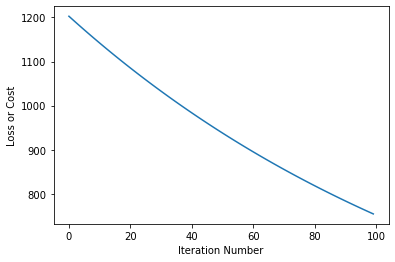

In [87]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iteration Number')
plt.ylabel('Loss or Cost')